# Evaluator Module
The Evaluator module creates evaluation reports.

Reports contain evaluation metrics depending on models specified in the evaluation config.

In [4]:
# reloads modules automatically before entering the execution of code
#load_ext autoreload
#autoreload 2

# third parties imports
import numpy as np 
import pandas as pd
# -- add new imports here --

# local imports
from configs import EvalConfig
from constants import Constant as C
from loaders import export_evaluation_report
from loaders import load_ratings
from models import get_top_n
# -- add new imports here --
import numpy as np
import pandas as pd
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from configs import EvalConfig 
from surprise import Dataset, Reader, accuracy
from constants import Constant as C
from surprise.model_selection import LeaveOneOut
from collections import defaultdict

# 1. Model validation functions
Validation functions are a way to perform crossvalidation on recommender system models. 

In [5]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from loaders import load_ratings, load_items # Assurez-vous que ces fonctions sont disponibles
import constants as C # Assurez-vous que vos constantes (C.EVIDENCE_PATH, C.RATINGS_FILENAME, etc.) sont bien définies
from constants import Constant as C


In [10]:
def load_ratings(surprise_format=False):
    df_ratings = pd.read_csv(C.EVIDENCE_PATH / C.RATINGS_FILENAME)
    if surprise_format:
        reader = Reader(rating_scale=C.RATINGS_SCALE)
        data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
        return data
    else:
        return df_ratings

def generate_split_predictions(algo, ratings_dataset, eval_config):
    """
    Generate predictions on a random test set specified in eval_config.
    
    Parameters:
        algo: A Surprise algorithm instance (e.g., SVD, KNNBasic).
        ratings_dataset: A Surprise Dataset object.
        eval_config: An EvalConfig object containing evaluation parameters (e.g., test_size).
    
    Returns:
        List of predictions made by the algorithm on the test set.
    """
    # Récupérer la proportion test depuis eval_config
    test_size = eval_config.test_size
    # Diviser le dataset en train/test
    trainset, testset = train_test_split(ratings_dataset, test_size=test_size)
    # Entraîner le modèle sur le trainset
    algo.fit(trainset)
    # Faire des prédictions sur le testset
    predictions = algo.test(testset)
    return predictions


def generate_loo_top_n(algo, ratings_dataset, eval_config):
    #Generate top-n recommendations for each user on a random Leave-one-out split (LOO)
    #leaveOneOut object with one split
    loo = LeaveOneOut(n_splits=1)
    # Split the dataset into training and testing sets
    trainset, testset = next(loo.split(ratings_dataset))
    # Train the algorithm on the training set
    algo.fit(trainset)
    # Generate the anti-testset
    anti_testset = trainset.build_anti_testset()
    # Generate predictions on the anti-testset
    predictions = algo.test(anti_testset)
    # Get top-N recommendations
    anti_testset_top_n = get_top_n(predictions, n=eval_config.top_n_value)
    return anti_testset_top_n, testset


def generate_full_top_n(algo, ratings_dataset, eval_config):
    #Generate top-n recommendations for each user with full training set (LOO)
    # Construire l’ensemble d’entraînement complet à partir de toutes les données
    full_trainset = ratings_dataset.build_full_trainset()

    # Entraîner l’algorithme sur toutes les données disponibles
    algo.fit(full_trainset)

    # Générer le anti-testset : tous les items que chaque utilisateur n’a pas encore notés
    anti_testset = full_trainset.build_anti_testset()

    # Générer les prédictions sur le anti-testset
    predictions = algo.test(anti_testset)

    # Extraire les top-N recommandations
    anti_testset_top_n = get_top_n(predictions, n=eval_config.top_n_value)

    return anti_testset_top_n 

def precompute_information():
    """Returns a dictionary that precomputes relevant information for evaluating in full mode
    and for initializing ContentBased models with pre-computed features and scalers.

    Dictionary keys:
    - precomputed_dict["item_to_rank"] : contains a dictionary mapping movie ids to rankings (from original code)
    - precomputed_dict["feature_stats"] : dictionary of min/max values for numeric features
    - precomputed_dict["tfidf_vectorizers"] : dictionary of pre-fitted TfidfVectorizer objects
    - precomputed_dict["one_hot_columns"] : dictionary of column names for one-hot encoded features
    """

    ratings = load_ratings()
    items = load_items() # Charger les items ici

    precomputed_dict = {}

    # --- 1. Informations existantes (popularité des films) ---
    item_counts = ratings['movieId'].value_counts().sort_values(ascending=False)
    precomputed_dict['item_to_rank'] = {movie: idx + 1 for idx, movie in enumerate(item_counts.index)}

    # --- 2. Précalcul des statistiques pour la normalisation des features numériques ---
    feature_stats = {}

    # title_length
    df_title_length = items[C.LABEL_COL].apply(lambda x: len(x)).to_frame('title_length')
    df_title_length['title_length'] = df_title_length['title_length'].fillna(0).astype(int)
    mean_title_length = int(df_title_length['title_length'].replace(0, np.nan).mean())
    feature_stats['title_length'] = {
        'min': df_title_length['title_length'].min(),
        'max': df_title_length['title_length'].max(),
        'mean_fillna': mean_title_length
    }

    # Year_of_release
    year = items[C.LABEL_COL].str.extract(r'\((\d{4})\)')[0].astype(float)
    df_year = year.to_frame(name='year_of_release')
    mean_year = df_year.replace(0, np.nan).mean().iloc[0]
    feature_stats['year_of_release'] = {
        'min': df_year['year_of_release'].min(),
        'max': df_year['year_of_release'].max(),
        'mean_fillna': mean_year
    }

    # average_ratings
    average_rating = ratings.groupby('movieId')[C.RATING_COL].mean().rename('average_rating').to_frame()
    global_avg_rating = ratings[C.RATING_COL].mean()
    feature_stats['average_rating'] = {
        'min': average_rating['average_rating'].min(),
        'max': average_rating['average_rating'].max(),
        'mean_fillna': global_avg_rating
    }

    # count_ratings
    rating_count = ratings.groupby('movieId')[C.RATING_COL].size().rename('rating_count').to_frame()
    rating_count['rating_count'] = rating_count['rating_count'].fillna(0).astype(int)
    mean_rating_count = int(rating_count['rating_count'].replace(0, np.nan).mean())
    feature_stats['count_ratings'] = {
        'min': rating_count['rating_count'].min(),
        'max': rating_count['rating_count'].max(),
        'mean_fillna': mean_rating_count
    }

    # TMDB features (vote_average, popularity, budget, revenue, runtime, vote_count, profit)
    tmdb_path = C.CONTENT_PATH / "tmdb_full_features.csv"
    df_tmdb = pd.read_csv(tmdb_path).drop_duplicates('movieId').set_index('movieId')

    for col in ['vote_average', 'popularity', 'budget', 'revenue', 'runtime', 'vote_count']:
        mean_val = df_tmdb[col].mean()
        feature_stats[f'tmdb_{col}'] = {
            'min': df_tmdb[col].min(),
            'max': df_tmdb[col].max(),
            'mean_fillna': mean_val
        }

    # Profit (dérivé du budget et revenue)
    df_tmdb['profit'] = df_tmdb['revenue'] - df_tmdb['budget']
    mean_profit = df_tmdb['profit'].mean()
    feature_stats['tmdb_profit'] = {
        'min': df_tmdb['profit'].min(),
        'max': df_tmdb['profit'].max(),
        'mean_fillna': mean_profit
    }
    
    precomputed_dict['feature_stats'] = feature_stats

    # --- 3. Pré-entraînement des TF-IDF Vectorizers ---
    tfidf_vectorizers = {}
    
    # Genre_tfidf
    items_copy = items.copy()
    items_copy['genre_string'] = items_copy[C.GENRES_COL].fillna('').str.replace('|', ' ', regex=False)
    tfidf_genre = TfidfVectorizer()
    tfidf_genre.fit(items_copy['genre_string'])
    tfidf_vectorizers['Genre_tfidf'] = tfidf_genre

    # Tags
    tags_path = C.CONTENT_PATH / "tags.csv"
    df_tags = pd.read_csv(tags_path)
    df_tags = df_tags.dropna(subset=['tag'])
    df_tags['tag'] = df_tags['tag'].astype(str)
    df_tags_grouped = df_tags.groupby('movieId')['tag'].agg(' '.join).to_frame('tags')
    tfidf_tags = TfidfVectorizer()
    tfidf_tags.fit(df_tags_grouped['tags'])
    tfidf_vectorizers['Tags'] = tfidf_tags

    # title_tfidf (avec lemmatisation et stopwords)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    items_copy['title_string_processed'] = items_copy[C.LABEL_COL].fillna('').apply(lambda x: ' '.join(
                                lemmatizer.lemmatize(word) for word in x.split() if word.lower() not in stop_words
                            ))
    tfidf_title = TfidfVectorizer()
    tfidf_title.fit(items_copy['title_string_processed'])
    tfidf_vectorizers['title_tfidf'] = tfidf_title

    # tmdb_cast
    df_tmdb_cast = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_cast['cast'] = df_tmdb_cast['cast'].fillna('')
    tfidf_cast = TfidfVectorizer()
    tfidf_cast.fit(df_tmdb_cast['cast'])
    tfidf_vectorizers['tmdb_cast'] = tfidf_cast

    # tmdb_director
    df_tmdb_director = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_director['director'] = df_tmdb_director['director'].fillna('')
    tfidf_director = TfidfVectorizer()
    tfidf_director.fit(df_tmdb_director['director'])
    tfidf_vectorizers['tmdb_director'] = tfidf_director

    precomputed_dict['tfidf_vectorizers'] = tfidf_vectorizers

    # --- 4. Colonnes pour One-Hot Encoding (pour garantir la cohérence des colonnes) ---
    one_hot_columns = {}

    # tmdb_original_language
    df_tmdb_lang = pd.read_csv(tmdb_path).drop_duplicates('movieId')
    df_tmdb_lang['original_language'] = df_tmdb_lang['original_language'].fillna('unknown')
    one_hot_columns['tmdb_original_language'] = pd.get_dummies(df_tmdb_lang['original_language'], prefix='lang').columns.tolist()
    
    precomputed_dict['one_hot_columns'] = one_hot_columns

    return precomputed_dict        


def create_evaluation_report(eval_config, sp_ratings, precomputed_dict, available_metrics):
    """ Create a DataFrame evaluating various models on metrics specified in an evaluation config.  
    """
    evaluation_dict = {}
    for model_name, model, arguments in eval_config.models:
        print(f'Handling model {model_name}')
        algo = model(**arguments)
        evaluation_dict[model_name] = {}
        
        # Type 1 : split evaluations
        if len(eval_config.split_metrics) > 0:
            print('Training split predictions')
            predictions = generate_split_predictions(algo, sp_ratings, eval_config)
            for metric in eval_config.split_metrics:
                print(f'- computing metric {metric}')
                assert metric in available_metrics['split']
                evaluation_function, parameters =  available_metrics["split"][metric]
                evaluation_dict[model_name][metric] = evaluation_function(predictions, **parameters) 

        # Type 2 : loo evaluations
        if len(eval_config.loo_metrics) > 0:
            print('Training loo predictions')
            anti_testset_top_n, testset = generate_loo_top_n(algo, sp_ratings, eval_config)
            for metric in eval_config.loo_metrics:
                assert metric in available_metrics['loo']
                evaluation_function, parameters =  available_metrics["loo"][metric]
                evaluation_dict[model_name][metric] = evaluation_function(anti_testset_top_n, testset, **parameters)
        
        # Type 3 : full evaluations
        if len(eval_config.full_metrics) > 0:
            print('Training full predictions')
            anti_testset_top_n = generate_full_top_n(algo, sp_ratings, eval_config)
            for metric in eval_config.full_metrics:
                assert metric in available_metrics['full']
                evaluation_function, parameters = available_metrics["full"][metric]
            # Pour novelty, passer item_to_rank comme argument
            if metric == "novelty":
                evaluation_dict[model_name][metric] = evaluation_function(
                anti_testset_top_n,
                item_to_rank=precomputed_dict["item_to_rank"],
                **parameters
                )
            else:
                evaluation_dict[model_name][metric] = evaluation_function(
                anti_testset_top_n,
                **parameters
                )
    return pd.DataFrame.from_dict(evaluation_dict).T 


# 2. Evaluation metrics
Implement evaluation metrics for either rating predictions (split metrics) or for top-n recommendations (loo metric, full metric)

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_hit_rate(anti_testset_top_n, testset):
    """Compute the average hit over the users (loo metric)
    
    A hit (1) happens when the movie in the testset has been picked by the top-n recommender
    A fail (0) happens when the movie in the testset has not been picked by the top-n recommender"""
    
   #implement the function get_hit_rate 
    hits = 0
    total = len(testset)  

    # Iterate through each entry in the testset
    for user_id, movie_id, _ in testset:
        top_n_recommendations = anti_testset_top_n.get(user_id, [])
        if movie_id in [recommended_movie[0] for recommended_movie in top_n_recommendations]:
            hits += 1 

    hit_rate = hits / total if total > 0 else 0
    return hit_rate


def get_novelty(anti_testset_top_n, item_to_rank):
    #Compute the average novelty of the top-n recommendation over the users (full metric)
    
    """The novelty is defined as the average ranking of the movies recommended"""
    
    total_rank = 0
    num_entries = 0
    total_items = len(item_to_rank)
    for user_recommendations in anti_testset_top_n.values():
        for movie_id, _ in user_recommendations:
            total_rank += item_to_rank.get(movie_id, total_items + 1)
            num_entries += 1
    average_rank_sum = total_rank / num_entries if num_entries > 0 else 0
    normalized_novelty = average_rank_sum / total_items  # Normalization step
    return normalized_novelty
    #return average_rank_sum """

def get_accuracy(predictions):
        """Compute the accuracy for rating predictions (split metric).
        Accuracy is defined as the proportion of predictions where the rounded predicted rating equals the true rating."""
        correct = 0
        total = len(predictions)
        for pred in predictions:
            if round(pred.est) == round(pred.r_ui):
                correct += 1
        return correct / total if total > 0 else 0

def get_precision(anti_testset_top_n, testset):
            """
            Compute the average precision over all users (loo metric).
            Precision is defined as the proportion of recommended items that are relevant (i.e., the test item is in the top-n recommendations).
            """
            hits = 0
            total_recommended = 0

            # Build a mapping from user to their test movie(s)
            test_movies = defaultdict(set)
            for user_id, movie_id, _ in testset:
                test_movies[user_id].add(movie_id)

            for user_id, recommendations in anti_testset_top_n.items():
                recommended_movies = set([movie_id for movie_id, _ in recommendations])
                relevant = test_movies.get(user_id, set())
                hits += len(recommended_movies & relevant)
                total_recommended += len(recommended_movies)

            precision = hits / total_recommended if total_recommended > 0 else 0
            return precision

def get_diversity(anti_testset_top_n):
    """
    Compute the average diversity of the top-n recommendations (full metric).
    Diversity is defined as the average pairwise dissimilarity between recommended items for each user.
    Here, we use the cosine distance between tag vectors as a proxy for dissimilarity.
    """

    # Load tags
    tags_df = pd.read_csv(r"C:\Users\Ooms Mathis\Documents\GitHub\Recommender-Systeem-\mlsmm2156\data\small\content\tags.csv")
    # Aggregate tags per movie
    movie_tags = tags_df.groupby('movieId')['tag'].apply(lambda tags: ' '.join(str(tag) for tag in tags)).to_dict()

    # Build TF-IDF vectors for tags
    movie_ids = list(movie_tags.keys())
    tag_corpus = [movie_tags[mid] for mid in movie_ids]
    vectorizer = TfidfVectorizer()
    tag_matrix = vectorizer.fit_transform(tag_corpus)
    movieid_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

    def cosine_distance(vec1, vec2):
        if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
            return 0
        return 1 - np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    diversities = []
    for user_recommendations in anti_testset_top_n.values():
        rec_movie_ids = [movie_id for movie_id, _ in user_recommendations]
        if len(rec_movie_ids) < 2:
            continue
        pairwise_distances = []
        for i in range(len(rec_movie_ids)):
            for j in range(i + 1, len(rec_movie_ids)):
                idx1 = movieid_to_idx.get(rec_movie_ids[i])
                idx2 = movieid_to_idx.get(rec_movie_ids[j])
                if idx1 is not None and idx2 is not None:
                    vec1 = tag_matrix[idx1].toarray().flatten()
                    vec2 = tag_matrix[idx2].toarray().flatten()
                    pairwise_distances.append(cosine_distance(vec1, vec2))
        if pairwise_distances:
            diversities.append(np.mean(pairwise_distances))
    return np.mean(diversities) if diversities else 0



# 3. Evaluation workflow
Load data, evaluate models and save the experimental outcomes

In [12]:

AVAILABLE_METRICS = {
    "split": {
        "mae": (accuracy.mae, {'verbose': False}),
        "rmse": (accuracy.rmse, {'verbose': False}),
        "accuracy": (get_accuracy, {}),
    },
    "loo": {
        "hit_rate": (get_hit_rate, {}),
        "precision": (get_precision, {}),
    },
    "full": {
        "novelty": (get_novelty, {}),
        "diversity" : (get_diversity, {}),
    
     } 
}

sp_ratings = load_ratings(surprise_format=True)
precomputed_dict = precompute_information()
# afficher les informations pré-calculées
print("Informations pré-calculées :")
for key, value in precomputed_dict.items():
    print(f"{key}: {value}")

evaluation_report = create_evaluation_report(EvalConfig, sp_ratings, precomputed_dict, AVAILABLE_METRICS)
print("Résultats de l'évaluation des 4 modèles :")
display(evaluation_report)   
print(evaluation_report)  
export_evaluation_report(evaluation_report)

Informations pré-calculées :
item_to_rank: {1240: 1, 1210: 2, 858: 3, 527: 4, 500: 5, 1208: 6, 590: 7, 1073: 8, 1968: 9, 2987: 10, 2011: 11, 34: 12, 6377: 13, 1225: 14, 923: 15, 5502: 16, 6333: 17, 2804: 18, 1219: 19, 4979: 20, 1092: 21, 5669: 22, 1250: 23, 899: 24, 2717: 25, 3499: 26, 1953: 27, 79132: 28, 49272: 29, 784: 30, 95: 31, 317: 32, 55820: 33, 1339: 34, 2006: 35, 3504: 36, 2746: 37, 4643: 38, 8622: 39, 6537: 40, 1345: 41, 708: 42, 509: 43, 8528: 44, 2724: 45, 3101: 46, 1032: 47, 1952: 48, 2881: 49, 5945: 50, 1172: 51, 673: 52, 2605: 53, 1095: 54, 5388: 55, 2427: 56, 3168: 57, 1212: 58, 2352: 59, 2953: 60, 2087: 61, 160: 62, 1299: 63, 3: 64, 91529: 65, 2942: 66, 1945: 67, 3450: 68, 515: 69, 1217: 70, 162: 71, 3362: 72, 1274: 73, 2501: 74, 535: 75, 494: 76, 3555: 77, 915: 78, 942: 79, 6323: 80, 2739: 81, 30749: 82, 37741: 83, 481: 84, 4105: 85, 2065: 86, 2805: 87, 4388: 88, 5064: 89, 2146: 90, 3146: 91, 44199: 92, 34319: 93, 3198: 94, 1779: 95, 2376: 96, 2642: 97, 3639: 98, 171

,mae,rmse,accuracy,hit_rate,precision,diversity
User_based_cosine,0.773567,0.996285,0.398036,0.065421,0.003271,0.956094
User_based_msd,0.766437,0.978750,0.391994,0.074766,0.003738,0.956094
User_based_pearson,0.777954,0.996559,0.365559,0.065421,0.003271,0.956094
User_based_pearson_baseline,0.769281,0.988674,0.382931,0.037383,0.001869,0.956094
user_based_jaccard,0.715752,0.932582,0.409366,0.074766,0.003738,0.969653


                                  mae      rmse  accuracy  hit_rate  \
User_based_cosine            0.773567  0.996285  0.398036  0.065421   
User_based_msd               0.766437  0.978750  0.391994  0.074766   
User_based_pearson           0.777954  0.996559  0.365559  0.065421   
User_based_pearson_baseline  0.769281  0.988674  0.382931  0.037383   
user_based_jaccard           0.715752  0.932582  0.409366  0.074766   

                             precision  diversity  
User_based_cosine             0.003271   0.956094  
User_based_msd                0.003738   0.956094  
User_based_pearson            0.003271   0.956094  
User_based_pearson_baseline   0.001869   0.956094  
user_based_jaccard            0.003738   0.969653  
Evaluation report successfully exported to: mlsmm2156\data\tiny\evaluations\evaluation_report_2025_05_27_1.csv


Commentaire:
MAE / RMSE :
La baseline 4 est de loin la plus performante et donc la plus précise selon ces deux indicateurs. Elle est suivie par la baseline 3. En revanche la baseline 1 est la moins performante ce qui en fait le modèle le moins précis.

Hit Rate :
Le taux de succès est très faible pour les baselines 1, 2 et 3, avec seulement environ 0,2 %, 0,4 % et 0,6 % respectivement dans ce cas. Cela montre leur incapacité à recommander efficacement des items pertinents. En revanche, la baseline 4 se distingue avec un Hit Rate nettement supérieur (5,2 %).

Novelty :
Les baselines 1, 2 et 3 obtiennent des scores de novelty relativement élevés, ce qui signifie qu’elles recommandent des items moins populaires. À l’inverse, la baseline 4 présente une valeur de nouveauté nettement plus faible ce qui indique qu’elle recommande majoritairement des films très vus. Cela maximise la précision mais se fait au détriment de la diversité des recommandations.

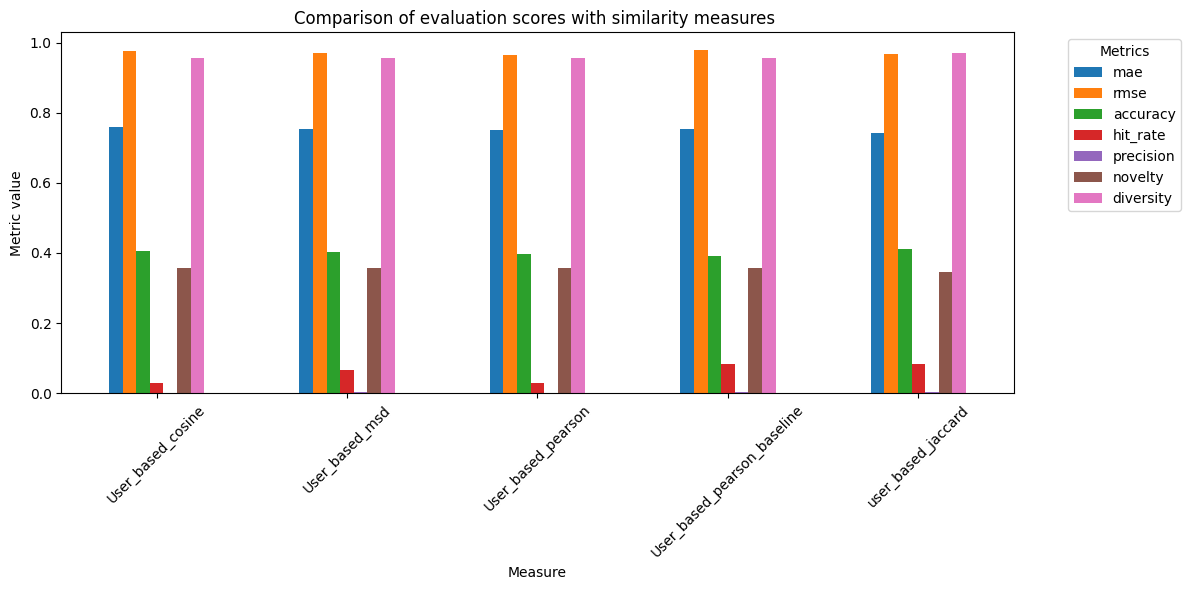

In [ ]:
import pandas as pd
from constants import Constant as C
import os

import matplotlib.pyplot as plt

def plot_evaluation_comparison(evaluation_df=None):
    """
    Affiche un graphique comparatif des scores pour chaque modèle.
    Les noms des modèles sont affichés en abscisse, chaque métrique est représentée par une barre.
    Si evaluation_df n'est pas fourni, utilise la variable globale evaluation_report.
    """
    if evaluation_df is None:
        evaluation_df = evaluation_report

    ax = evaluation_df.plot(kind='bar', figsize=(12, 6))
    plt.title("Comparison of evaluation scores with similarity measures ")
    plt.ylabel("Metric value")
    plt.xlabel("Measure")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
plot_evaluation_comparison()